In [1]:
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import mygene
import pickle
import scipy.stats

%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# Loading Data
Loading matrix with marker genes

In [2]:
markers = pd.read_excel('../../benchmarking_data/41587_2020_469_MOESM4_ESM.xlsx', skiprows=2)
cols = markers.columns
cols = [x.replace(' ', '_') for x in cols]
cols = [x.replace('+', '') for x in cols]
cols = [x.replace('-', '_') for x in cols]
cols = [x.replace('_cell', '') for x in cols]
markers.columns = cols

Loading expression matrix

In [3]:
tdata = pd.read_table("../../benchmarking_data/GSE133535_10X2x5Kcell250Kreads_human_exp_mat.tsv.gz", compression='gzip')
adata = anndata.AnnData(tdata.T)

Loading metadata

In [4]:
metadata = pd.read_table("../../benchmarking_data/GSE133535_10X2x5Kcell250Kreads_human_metada.tsv.gz", compression='gzip')

Loading cell annotations and filtering out genes expressed by less than 5 cells

In [5]:
hca_annot = pd.read_table("../../benchmarking_data/HCA_annotations.txt")

cells = [x for x in hca_annot.query('batch == "Chromium"').index if x in adata.obs_names]

adata = adata[cells]

adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
sc.pp.filter_genes(adata, min_cells=5)

Trying to set attribute `.obs` of view, copying.


# Preprocessing
Decodification of Ensamble gene id in gene symbol through mygene library

In [6]:
mg = mygene.MyGeneInfo()

In [7]:
ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-27444...done.
Finished.
27 input query terms found dup hits:
	[('ENSG00000002586', 2), ('ENSG00000124333', 2), ('ENSG00000167393', 2), ('ENSG00000168939', 2), ('E
150 input query terms found no hit:
	['ENSG00000116883', 'ENS

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


In [8]:
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        

Filtering step: cells are filtered by several parameters.



1) Cells in which expression of mitochondrial genes accounts for more than the 25% of total gene expression are discarted



2) The 5% of cells characterized by the highest number of genes are discarted

In [9]:
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]

Trying to set attribute `.obs` of view, copying.


Cells are then normalized and only highly variable genes are selected in order to perform further analysis. After that, the effects of total counts per cell and the percentage of mitochondrial genes expressed are regressed out.

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:1171: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical


# Principal component analysis (PCA)
Dimensionality reduction of data using PCA

In [11]:
sc.tl.pca(adata)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


# Computing the neighborhood graph
Computation of the neighborhood graph, thanks to PCA reppresentation of the data matrix. The following values are selected, because they improve nSBM clustering performance

In [12]:
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:02)


# Embedding the neighborhood graph
The graph is embedded in 2 dimensions, using UMAP

In [13]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:03)


# Clustering the neighborhood graph
The clustering is performed using nested Stochastich Block Model (nSBM) and a hierarcal graph is obtained. Groups of each level are processed as cells in the following level, therefore they are furtherly clustered since a level with a single cluster is reached.



Here the clustering is performed without the equilibration step, and the graph obtained is degree corrected and unweighted.

In [14]:
schist.inference.nested_model(adata, equilibrate=False,deg_corr=True, use_weights=False,n_init=3)

minimizing the nested Stochastic Block Model
    done (0:03:01)
    calculating cell affinity to groups
    finished (0:03:04)


Anndata (.h5ad format) and NestedBlockState (.pkl format) files are dumped as separate file with our read/write function

In [15]:
schist.io.write(adata, prefix='anndata_notebooks/10XV3_notebook')

In [16]:
adata=schist.io.read('anndata_notebooks/10XV3_notebook')

# Plotting clusters
Selection of the most descriptive levels, according to the modularity measure of each level in the hierarchy

<BarContainer object of 10 artists>

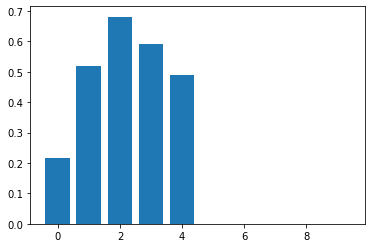

In [17]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

Plotting of clusters of level 2 ('nsbm_level_2') and comparison with cell annotation ('nnet2')

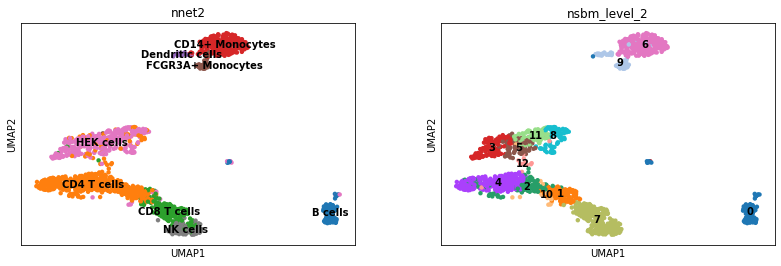

In [18]:
sc.pl.umap(adata, color=['nnet2', 'nsbm_level_2'], ncols=2, legend_loc='on data')

Plotting of clusters of level 3 ('nsbm_level_3') and comparison with cell annotation ('nnet2')

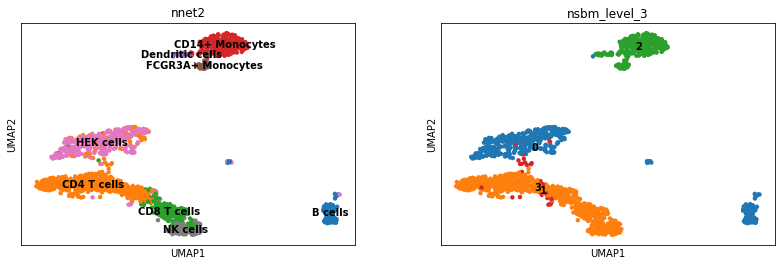

In [19]:
sc.pl.umap(adata, color=['nnet2', 'nsbm_level_3'], ncols=2, legend_loc='on data')